# Study of the synonymous mutations

Created: **19/07/18**  
Last modified: **03/08/18**

**Goal:** this study will focus only on the `synonymous_SNV` mutations.  
This notebook is divided in ? (independant) parts:
* **1. Bla**: `coding_analysis.ipynb [Pierre]` ( part 1. The `class` feature: somatic vs non-somatic)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-label-feature:-coding_somatic-vs-synonymous" data-toc-modified-id="The-label-feature:-coding_somatic-vs-synonymous-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The <code>label</code> feature: coding_somatic vs synonymous</a></span><ul class="toc-item"><li><span><a href="#Creating-the-feature" data-toc-modified-id="Creating-the-feature-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating the feature</a></span></li><li><span><a href="#Comparison-of-the-frequency_in_normals,-t_vaf-and-strand_ratio" data-toc-modified-id="Comparison-of-the-frequency_in_normals,-t_vaf-and-strand_ratio-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Comparison of the <code>frequency_in_normals</code>, <code>t_vaf</code> and <code>strand_ratio</code></a></span></li><li><span><a href="#Comparison-of-Kaviar_AF" data-toc-modified-id="Comparison-of-Kaviar_AF-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Comparison of <code>Kaviar_AF</code></a></span></li><li><span><a href="#Comparison-of-cosmic_count" data-toc-modified-id="Comparison-of-cosmic_count-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Comparison of <code>cosmic_count</code></a></span></li></ul></li><li><span><a href="#The-key-feature:-study-of-reccurent-mutations" data-toc-modified-id="The-key-feature:-study-of-reccurent-mutations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The <code>key</code> feature: study of reccurent mutations</a></span><ul class="toc-item"><li><span><a href="#Identify-the-reccurent-mutations" data-toc-modified-id="Identify-the-reccurent-mutations-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Identify the reccurent mutations</a></span></li><li><span><a href="#Sudy-the-reccurent-mutations-genes" data-toc-modified-id="Sudy-the-reccurent-mutations-genes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sudy the reccurent mutations genes</a></span></li><li><span><a href="#Study-the-outliers" data-toc-modified-id="Study-the-outliers-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Study the outliers</a></span></li></ul></li></ul></div>

***

In [84]:
source("../../../src/utils/custom_tools.R")
setup_environment("../../../src/utils")

In [85]:
impact <- read.table("../../../data/cleaned_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)
impact <- add_features("../../../data/", impact, annotations = TRUE)

## The `label` feature: coding_somatic vs synonymous

The `synonymous_SNV` mutations have automatically been classified as `UNKNOWN` so we don't know which one are somatic or non-somatic mutations. However, the coding mutations have been curated, and we know which one of them are somatic. Thus, we can take the somatic coding mutations as a reference of mutations that are somatic. For example, comparing the `frequency_in_normals` for `synonymous_SNV` mutations and somatic coding mutations could reveal a difference and help us to filter the `synonymous_SNV` mutations that are somatic from the one that are non-somatic.  

Unfortunately, this study will show that the `frequency_in_normals`, `t_vaf` and `strand_bias` features won't be relevant to filter the `synonymous_SNV` mutations. However, the `Kaviar_AF` feature could help us!

### Creating the feature

We create a new feature `label`:
* A mutation has `label = synonymous` if `Consequence = synonymous_SNV`
* A mutation has `label = coding_somatic` if it is a coding mutation and `confidence_class = AUTO_OK | MANUAL_OK`.

In [86]:
impact <- impact[(impact$Consequence == "synonymous_SNV") |
                 (impact$Consequence != "synonymous_SNV" & (impact$confidence_class == "AUTO_OK" |
                                                            impact$confidence_class == "MANUAL_OK")),]
impact$label <- "coding_somatic"
impact$label[(impact$Consequence == "synonymous_SNV")] <- "synonymous"

addmargins(table(impact$label, impact$confidence_class), margin = 2)
100 * nrow(impact[impact$label == "synonymous",]) / nrow(impact) # percentage of synonymous mutations

,AUTO_OK,MANUAL_OK,UNKNOWN,Sum
coding_somatic,180763,6335,0,187098
synonymous,0,0,50010,50010


[1] 21.09165

The dataset is unbalanced with 50,010 synonymous mutations ($21.1\%$ of the samples) vs 187,098 somatic mutations ($78.9\%$ of the samples).

### Comparison of the `frequency_in_normals`, `t_vaf` and `strand_ratio`

We create the `strand_ratio` feature:

In [87]:
impact$strand_ratio <- pmin(impact$t_alt_neg_count, impact$t_alt_plus_count) /
                       pmax(impact$t_alt_neg_count, impact$t_alt_plus_count)

Distribution of `frequency_in_normals`, `tvaf` and `strand_ratio` for the coding vs synonymous `label` (warning the first and last plot have a sqrt x and sqrt y scale):

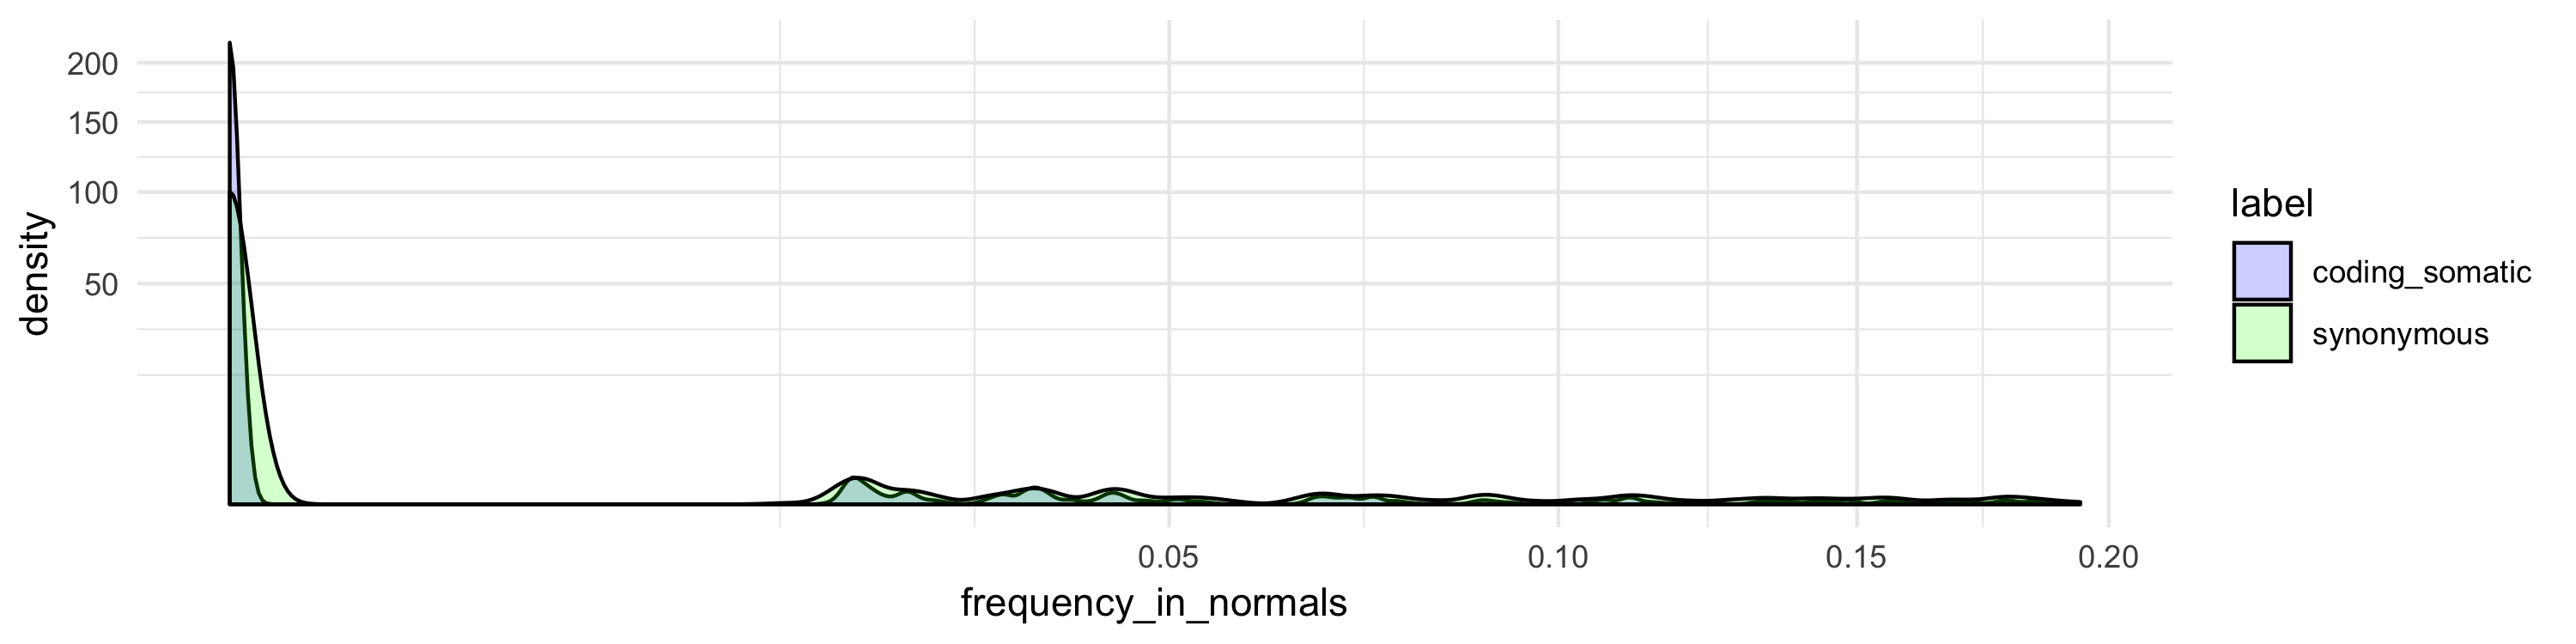

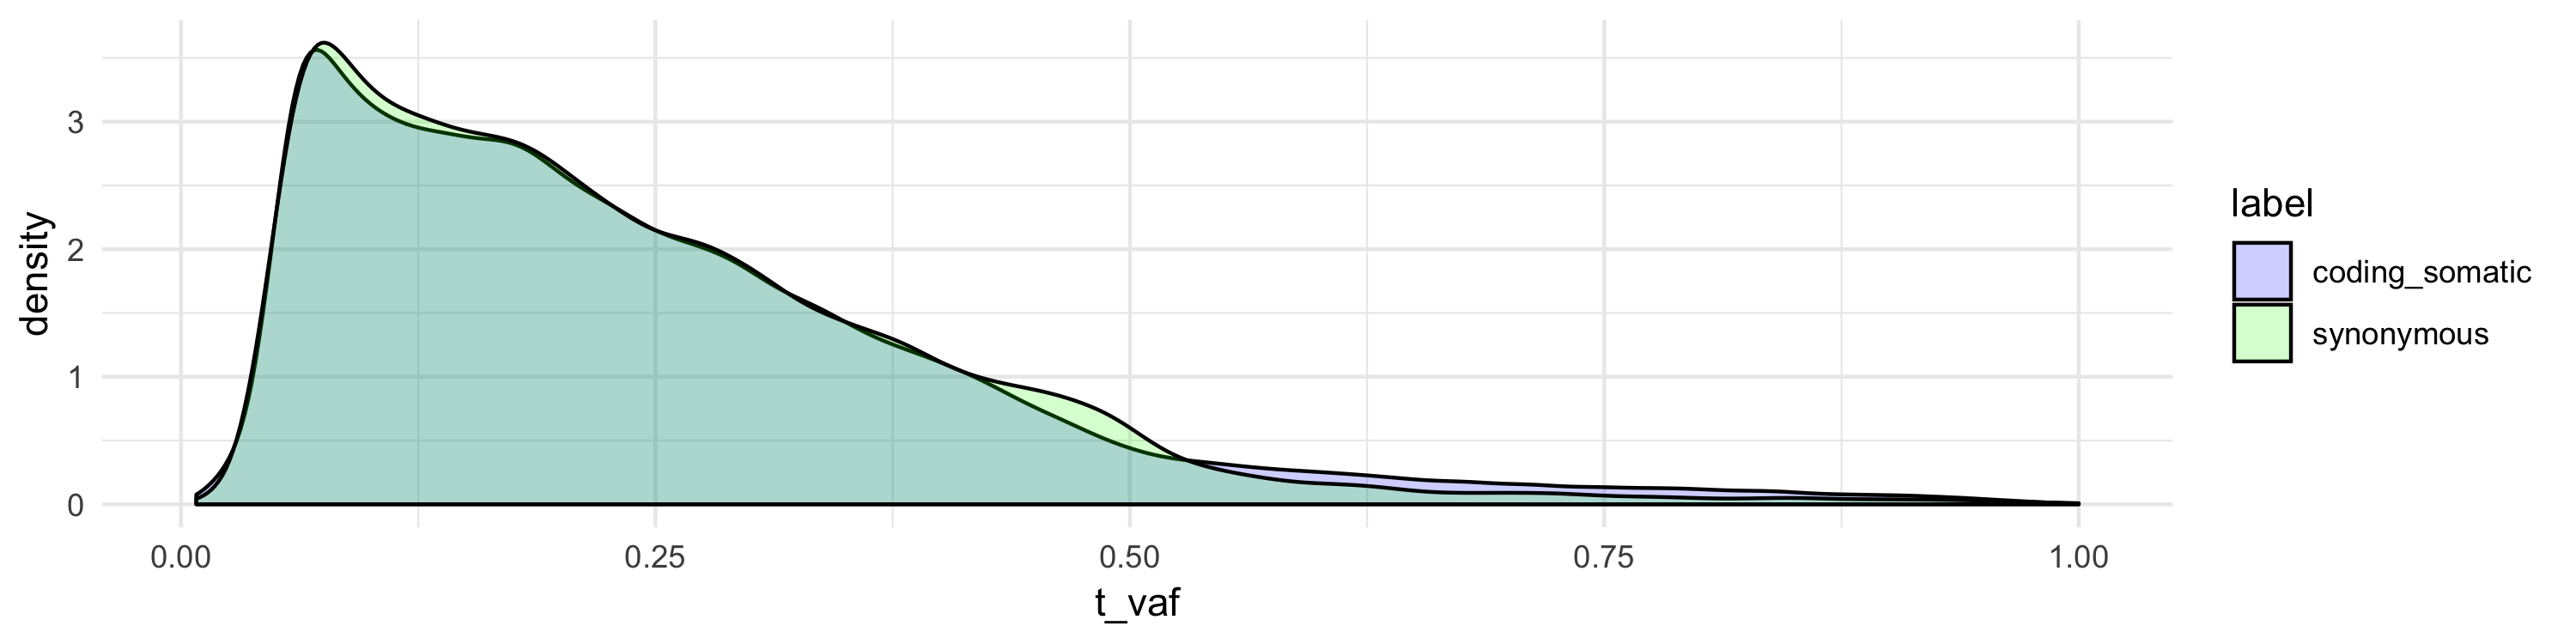

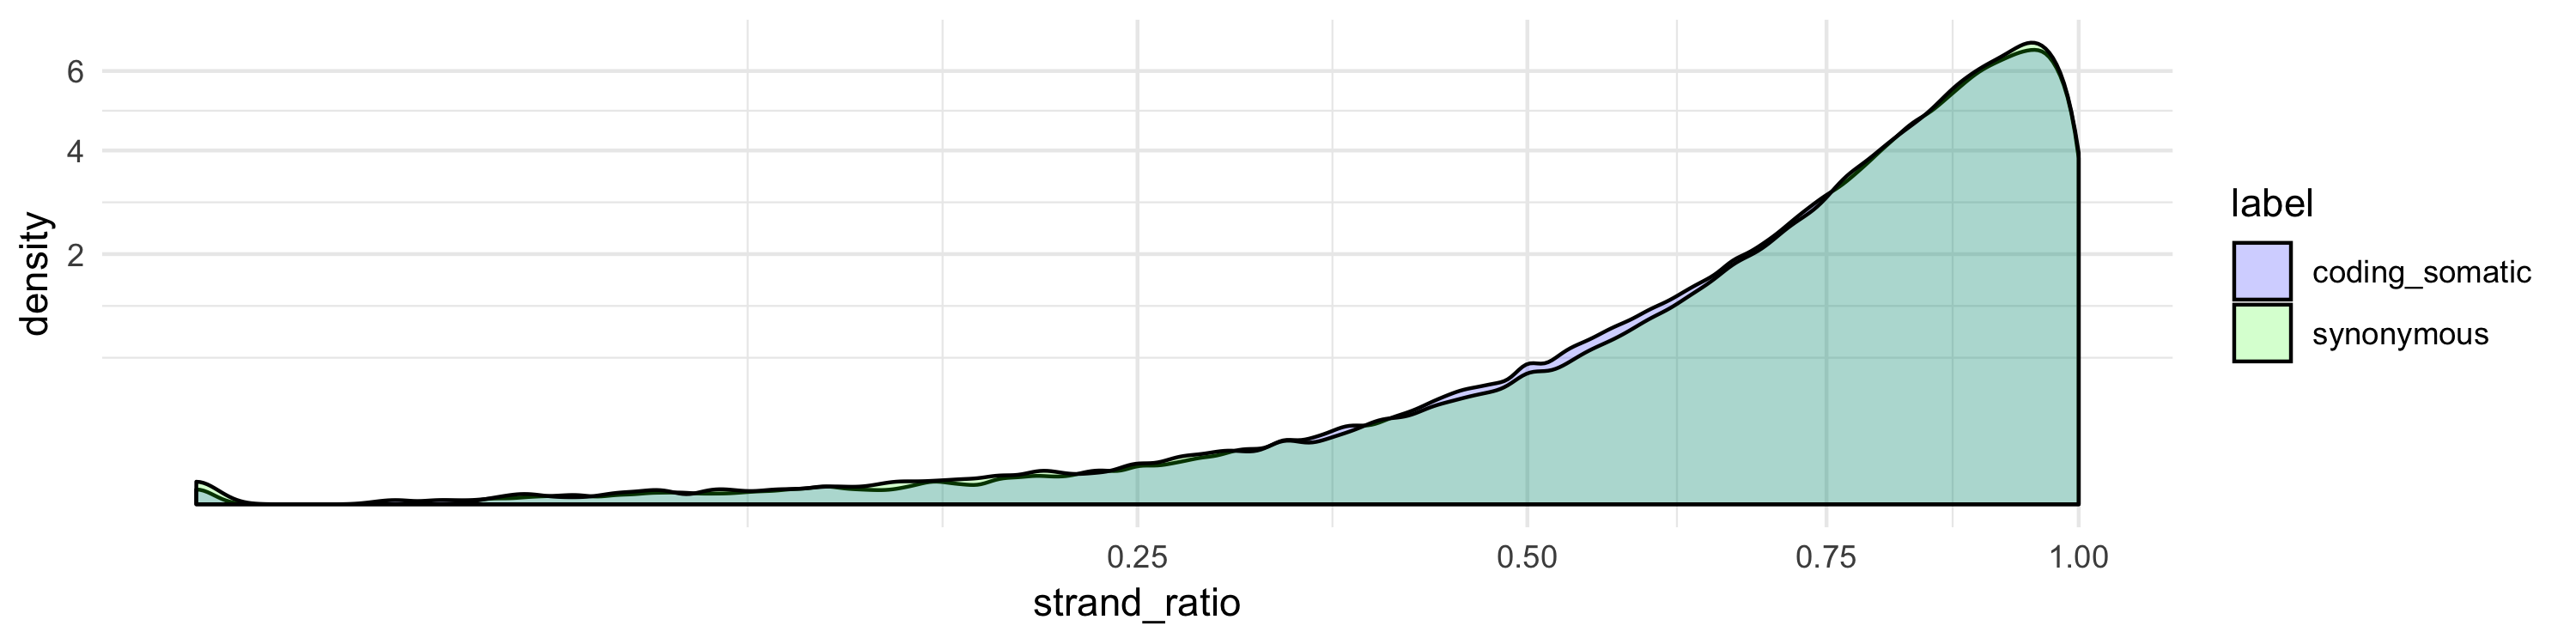

In [88]:
plot_density(impact, "frequency_in_normals", "label", height = 2.5) + scale_x_sqrt() + scale_y_sqrt()
plot_density(impact, "t_vaf", "label", height = 2.5)
plot_density(impact, "strand_ratio", "label", height = 2.5) + scale_x_sqrt() + scale_y_sqrt()

The distributions are almost identical in every plot. Wee see a little bump at `t_vaf` $\approx 0.5$ for the synonymous mutations, most likely the germline part of it but it is really not pronounced.

Below is an attempt to plot the `strand_ratio` vs the `t_vaf` to separate the germline (`t_vaf` $\approx 0.5$ and high `strand_ratio`) from the artefact (low `t_vaf` and low `strand_ratio`), but nothing really discriminant was found.

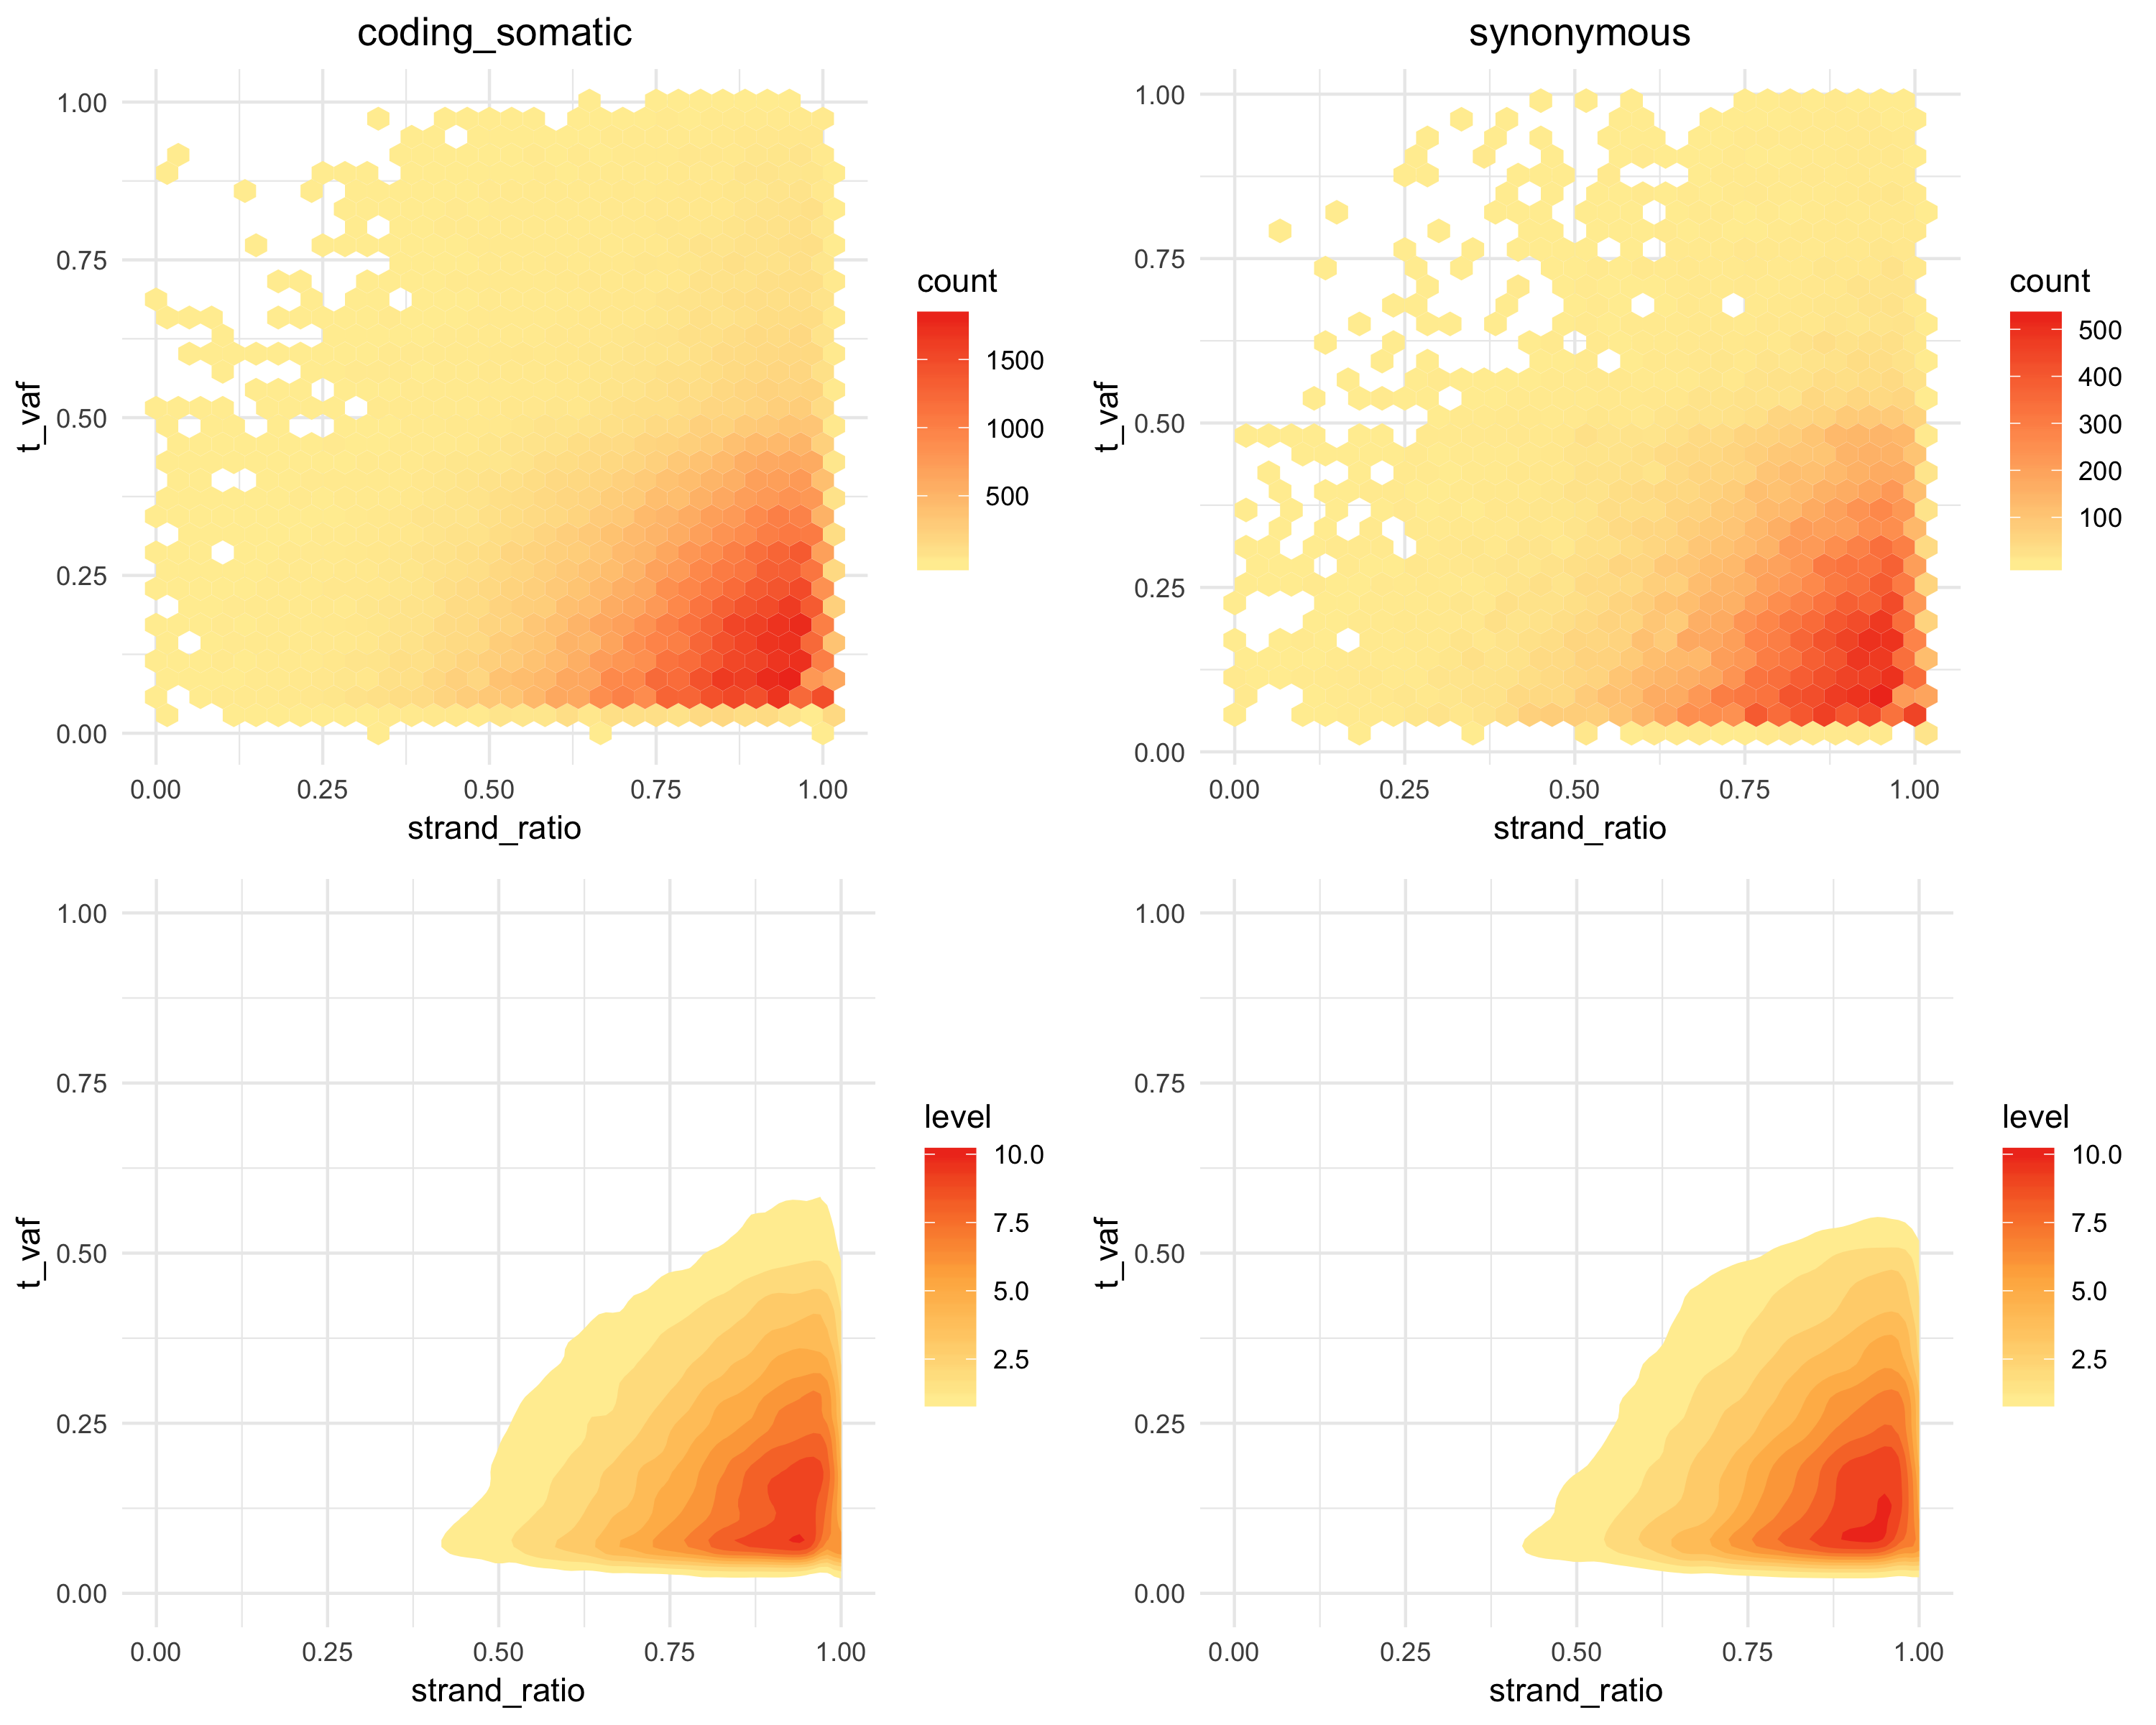

In [89]:
notebook_plot_size(10, 8)
plot1 <- ggplot(impact[impact$label == "coding_somatic",]) + geom_hex(aes(strand_ratio, t_vaf)) +
         scale_fill_gradient(low = "#FFEDA0", high = "#F03B20") +
         ggtitle("coding_somatic") + theme(plot.title = element_text(hjust = 0.5))
plot2 <- ggplot(impact[impact$label == "synonymous",]) + geom_hex(aes(strand_ratio, t_vaf)) +
         scale_fill_gradient(low = "#FFEDA0", high = "#F03B20") +
         ggtitle("synonymous") + theme(plot.title = element_text(hjust = 0.5))
plot3 <- ggplot(impact[impact$label == "coding_somatic",]) +
         stat_density_2d(aes(strand_ratio, t_vaf, fill = ..level..), geom = "polygon") +
         scale_fill_gradientn(colors = c("#FFEDA0", "#FEB24C", "#F03B20")) +
         coord_cartesian(xlim = c(0, 1), ylim = c(0, 1))
plot4 <- ggplot(impact[impact$label == "synonymous",]) +
         stat_density_2d(aes(strand_ratio, t_vaf, fill = ..level..), geom = "polygon") +
         scale_fill_gradientn(colors = c("#FFEDA0", "#FEB24C", "#F03B20")) +
         coord_cartesian(xlim = c(0, 1), ylim = c(0, 1))

plot_grid(plot1, plot2, plot3, plot4, ncol = 2, nrow = 2)

### Comparison of `Kaviar_AF`

Distribution of `Kaviar_AF` for the coding vs synonymous `label` (warning this is a sqrt x and sqrt y scale):

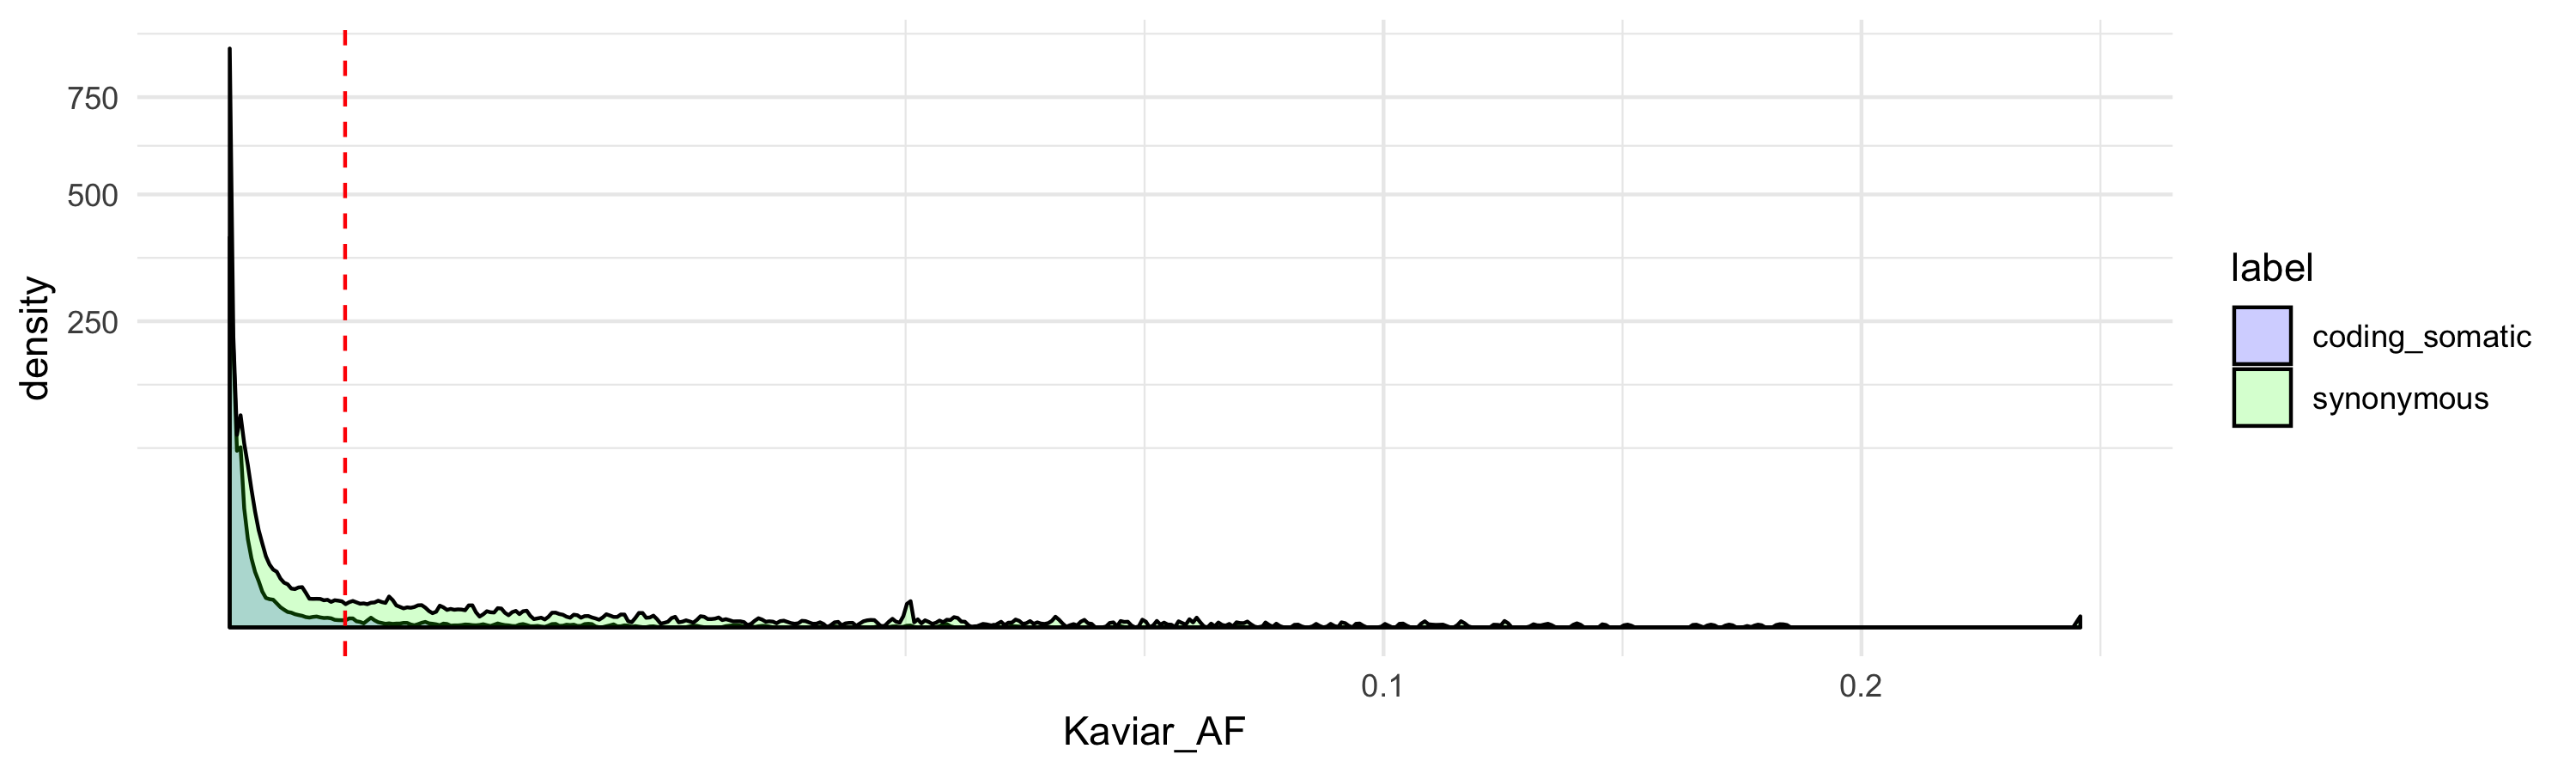

In [90]:
plot_density(impact, "Kaviar_AF", "label", lines = 0.001) + scale_x_sqrt() + scale_y_sqrt()

The synonymous mutations present a heavier `Kaviar_AF` tail, which are likely to be the artefacts call.

In [91]:
summary(impact[impact$label == "coding_somatic",]$Kaviar_AF)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.000000 0.000000 0.000000 0.000026 0.000000 0.172999 

In [92]:
summary(impact[impact$label == "synonymous",]$Kaviar_AF)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0005996 0.0000065 0.2572410 

In [93]:
100 * nrow(impact[impact$label == "coding_somatic" & impact$Kaviar_AF > 0.001,]) / nrow(impact[impact$label == "coding_somatic",])
100 * nrow(impact[impact$label == "synonymous" & impact$Kaviar_AF > 0.001,]) / nrow(impact[impact$label == "synonymous",])

[1] 0.2768603

[1] 4.173165

We are going to set a threshold on the `Kaviar_AF` parameter to try to curate the `synonymous` mutations, even if the threshold is a bit severe and will make us loose some somatic synonymous, we should still be able to work on a sufficient amount of `synonymous` mutations. The threshold will be set at 0.001 (see red line on the plot above).

In [94]:
impact <- impact[impact$label != "synonymous" |
                 (impact$label == "synonymous" & impact$Kaviar_AF <= 0.001),]

### Comparison of `cosmic_count`

Distribution of `cosmic_count` for the coding vs synonymous `label` (warning this is a sqrt x and sqrt y scale):

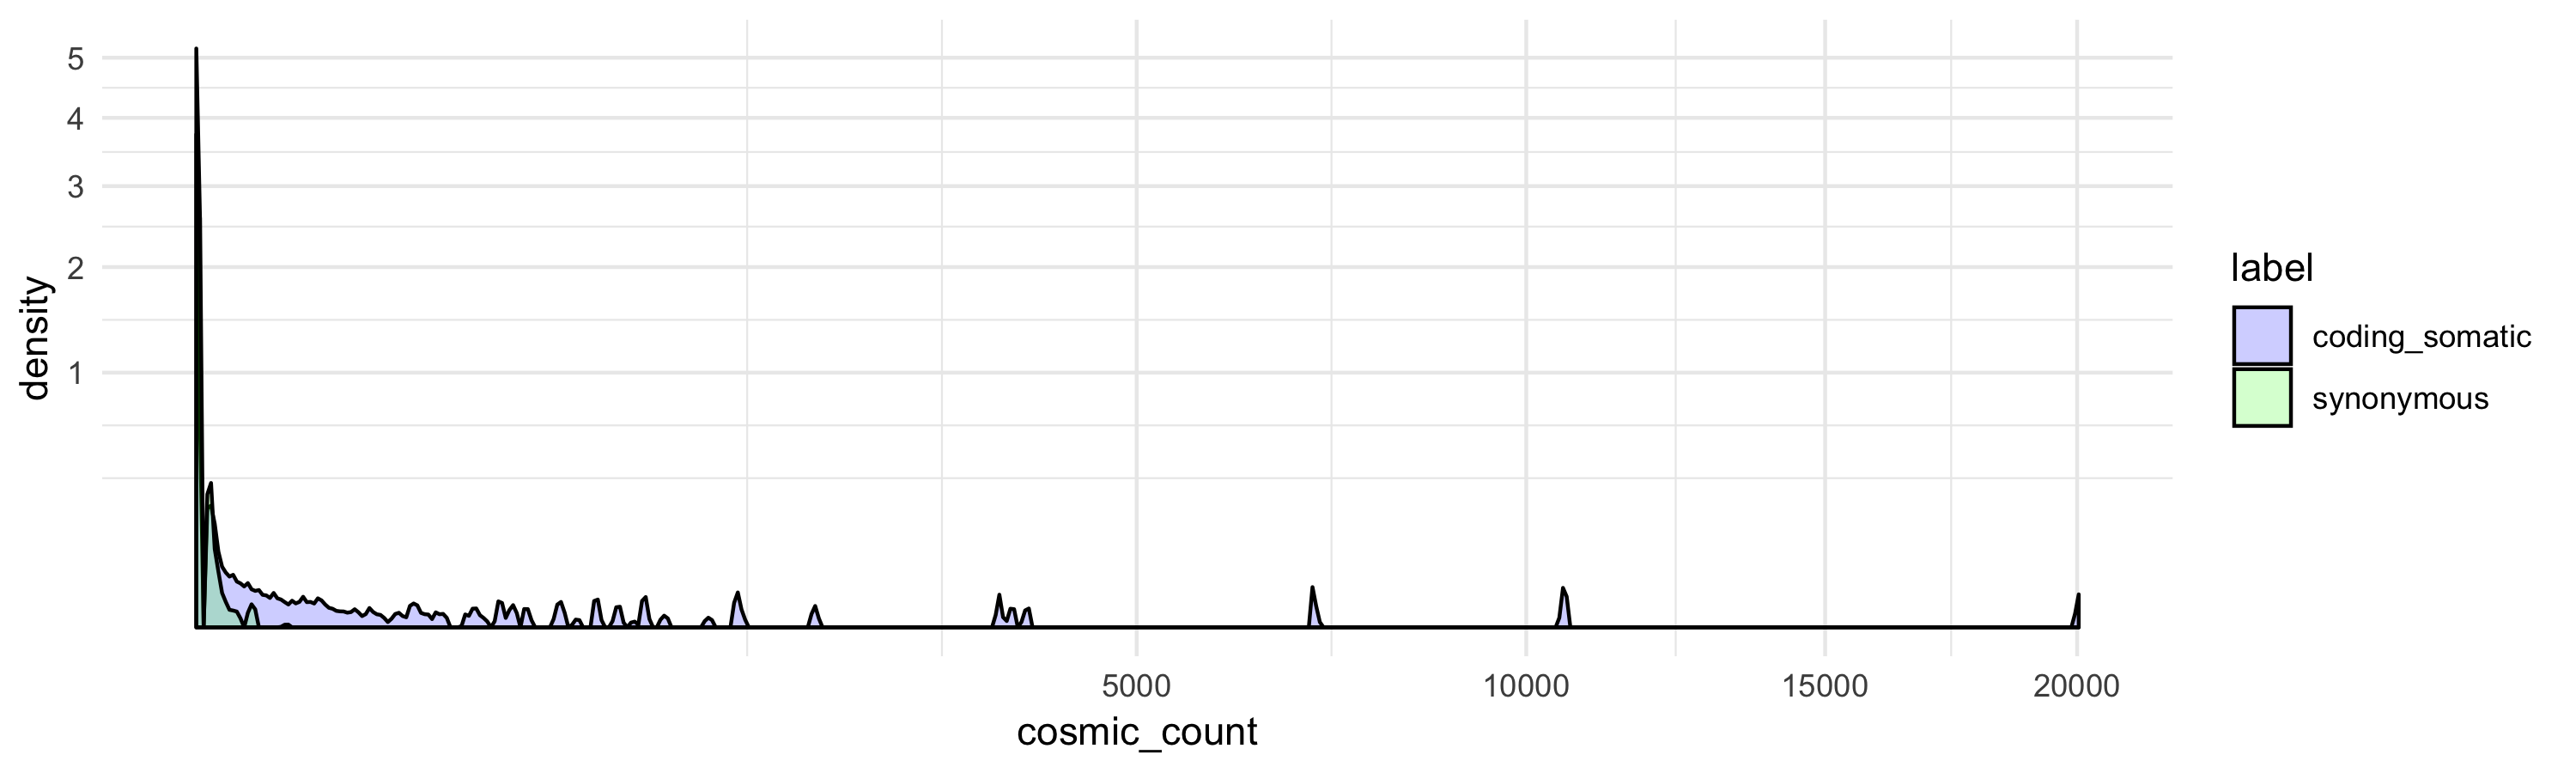

In [95]:
plot_density(impact, "cosmic_count", "label") + scale_x_sqrt() + scale_y_sqrt()

As expected the `synonymous` mutations have a really low `cosmic_count`.

In [96]:
summary(impact[impact$label == "synonymous",]$cosmic_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1262  0.0000 46.0000 

## The `key` feature: study of reccurent mutations

In [97]:
impact <- impact[impact$label == "synonymous",] # keep only the synonymous mutations

Each mutations is identified by a unique key `mut_key` : `Chromosome`_`Start_Position`_`Reference_Allele`_`Tumor_Seq_Allele2`. The mutations sharing the same key are the same.

In [98]:
head(impact$mut_key)
length(unique(impact$mut_key)) # number of different keys e.g. number of different mutations

[1] "1_27101572_C_G"  "19_5244030_C_G"  "1_162740271_C_T" "3_134977903_C_T"
[5] "X_123197875_C_A" "3_189612072_C_T"

[1] 38968

### Identify the reccurent mutations

We need to study the reccurence of mutations taking care not to consider a mutation as recurrent if it comes frome the same patient. To do so we will group the rows by patient, and select only the distinct mutations for each patient:

In [99]:
# create a patient id (no problem will be caused by 'None-T01-IM6' which will become 'None-T01-')
impact$patient_id <- substr(impact$Tumor_Sample_Barcode, 1, 9)
head(unique(impact$patient_id))

[1] "P-0000012" "P-0000026" "P-0000027" "P-0000030" "P-0000039" "P-0000037"

In [100]:
impact_unique_mut_keys_per_patient <- as.data.frame(impact %>% group_by(patient_id) %>%
                                                               select(patient_id, mut_key, Hugo_Symbol) %>%
                                                               filter(! duplicated(mut_key)))
nrow(impact)
nrow(impact_unique_mut_keys_per_patient)

[1] 47923

[1] 46275

In [101]:
mut_key_info <- as.data.frame(impact_unique_mut_keys_per_patient %>% group_by(mut_key) %>%
                                                                     summarise(count = n(), Hugo_Symbol = unique(Hugo_Symbol)))
head(mut_key_info)

mut_key,count,Hugo_Symbol
1_11168249_G_A,1,MTOR
1_11168276_C_G,1,MTOR
1_11168276_C_T,1,MTOR
1_11168327_A_G,1,MTOR
1_11168339_C_T,1,MTOR
1_11169351_G_A,1,MTOR


In [102]:
for (threshold in c(2, 3, 5, 10)) {
    
    mut_key_info_threshold <- mut_key_info[mut_key_info$count >= threshold,]
    
    print(sprintf("%2.0f%% (%5d) of the keys are shared by at least %2d samples [%2.0f%% (%5d) of the rows concerned]",
                  100 * nrow(mut_key_info_threshold) / nrow(mut_key_info),
                  nrow(mut_key_info_threshold),
                  threshold,
                  100 * nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,]) / nrow(impact_unique_mut_keys_per_patient),
                  nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,])))
}

[1] "13% ( 4921) of the keys are shared by at least  2 samples [26% (12228) of the rows concerned]"
[1] " 3% ( 1226) of the keys are shared by at least  3 samples [10% ( 4838) of the rows concerned]"
[1] " 1% (  198) of the keys are shared by at least  5 samples [ 3% ( 1535) of the rows concerned]"
[1] " 0% (   32) of the keys are shared by at least 10 samples [ 1% (  568) of the rows concerned]"


Distribution of the mutations key count for the mutations present in at least 2 samples (warning this is a sqrt x and y scale):

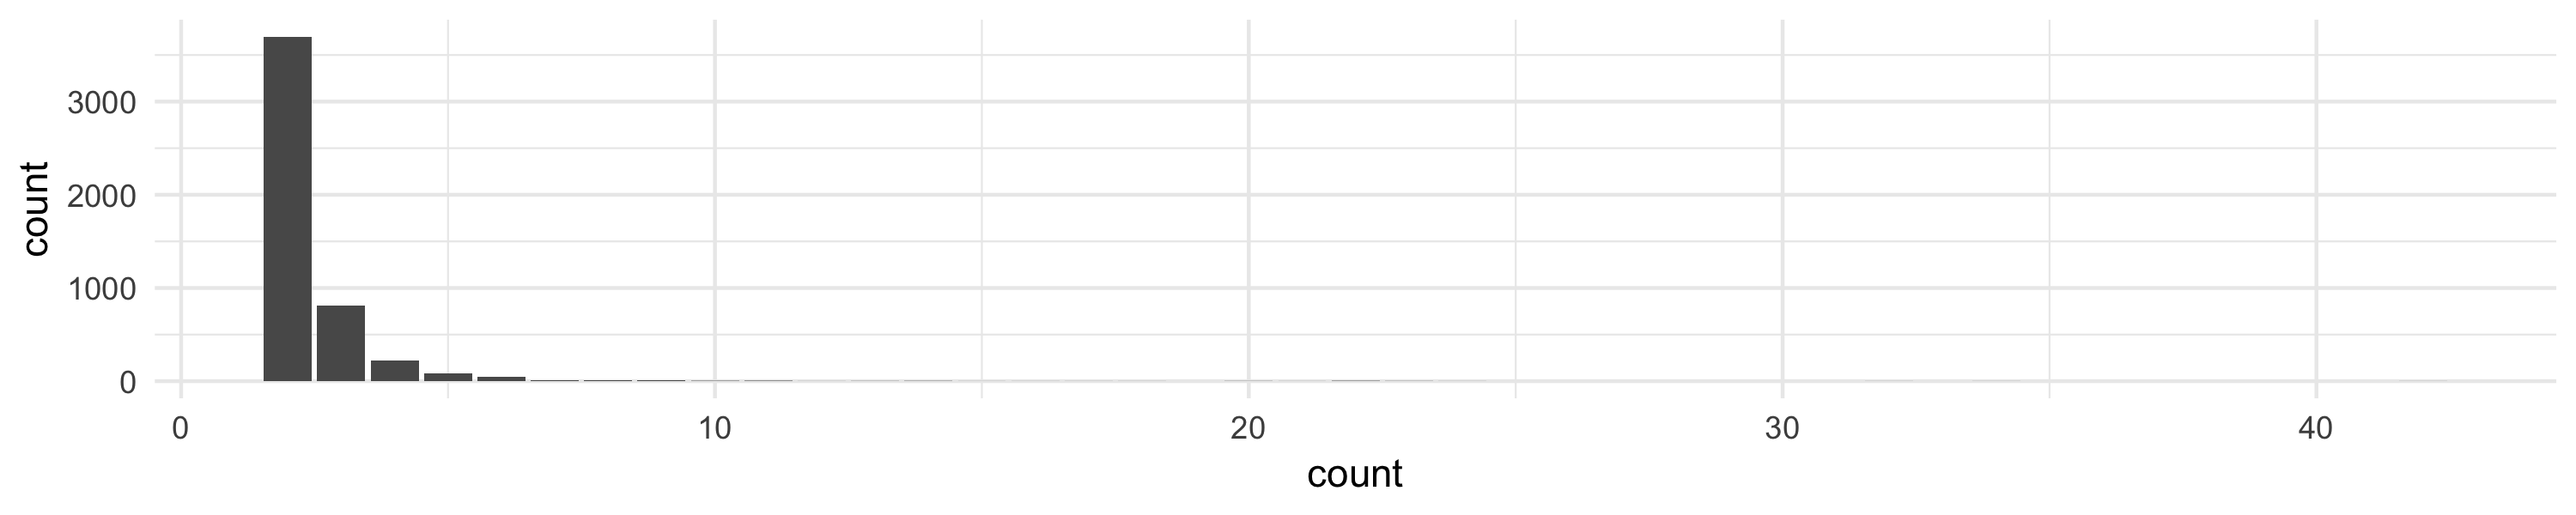

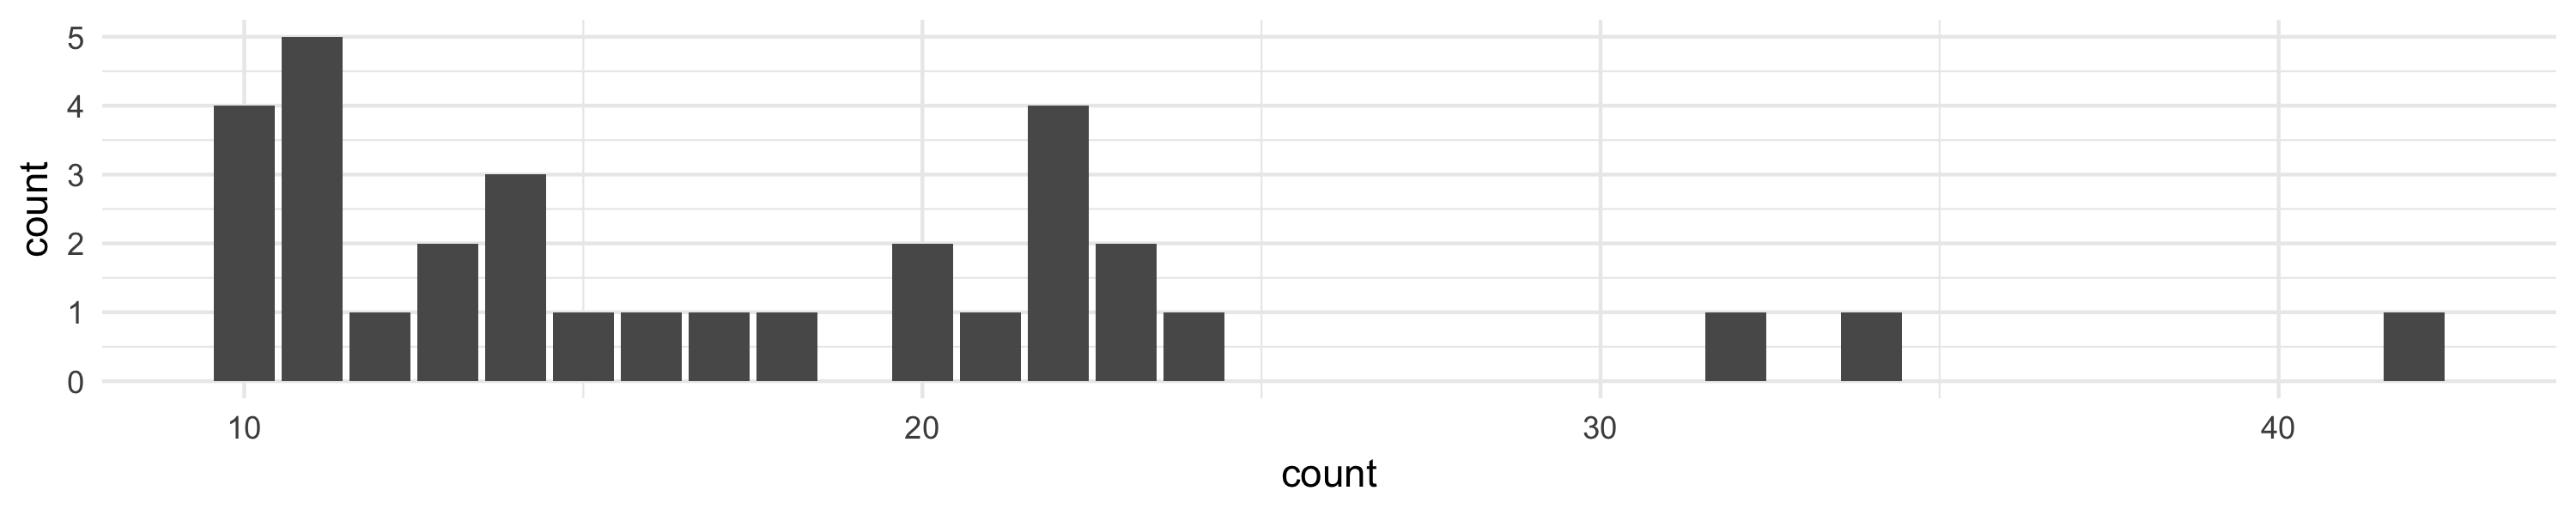

In [142]:
repeated_key <- mut_key_info[mut_key_info$count >= 2,] # keys shared by at least 2 samples
ggplot(repeated_key) + geom_bar(aes(x = count))
ggplot(repeated_key[repeated_key$count >= 10,]) + geom_bar(aes(x = count))

### Sudy the reccurent mutations genes

In [104]:
length(unique(repeated_key$Hugo_Symbol))

[1] 448

In [105]:
head(repeated_key)

,mut_key,count,Hugo_Symbol
7,1_11169411_C_T,2,MTOR
11,1_11169776_G_A,2,MTOR
20,1_11181321_C_G,3,MTOR
27,1_11182069_G_A,2,MTOR
30,1_11182162_G_A,2,MTOR
38,1_11184683_G_A,2,MTOR


Here is a plot of the genes that are the most mutated **accross the mutation keys**:

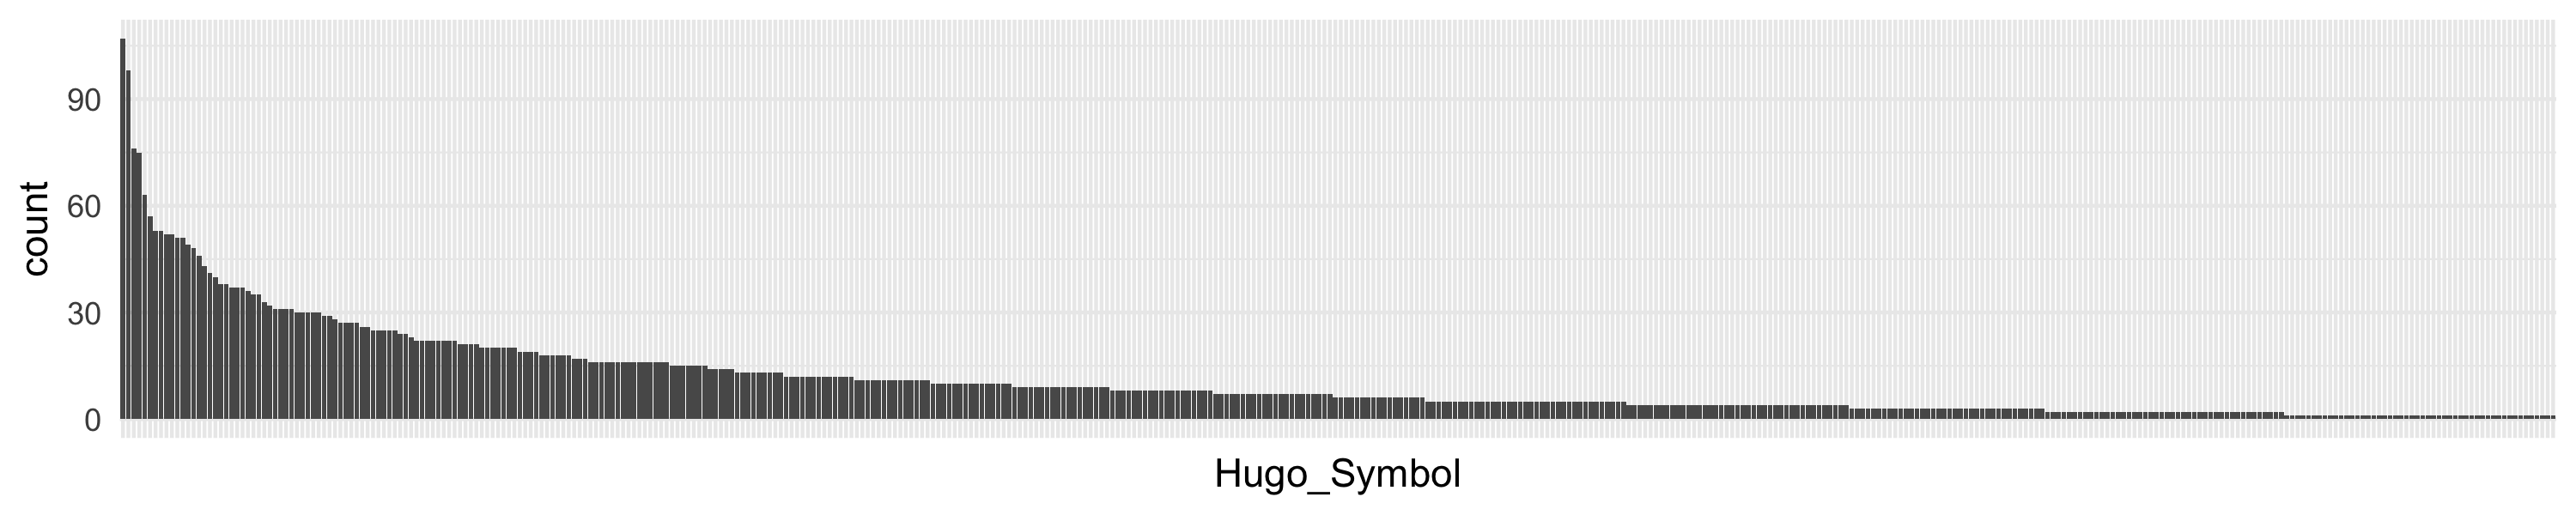

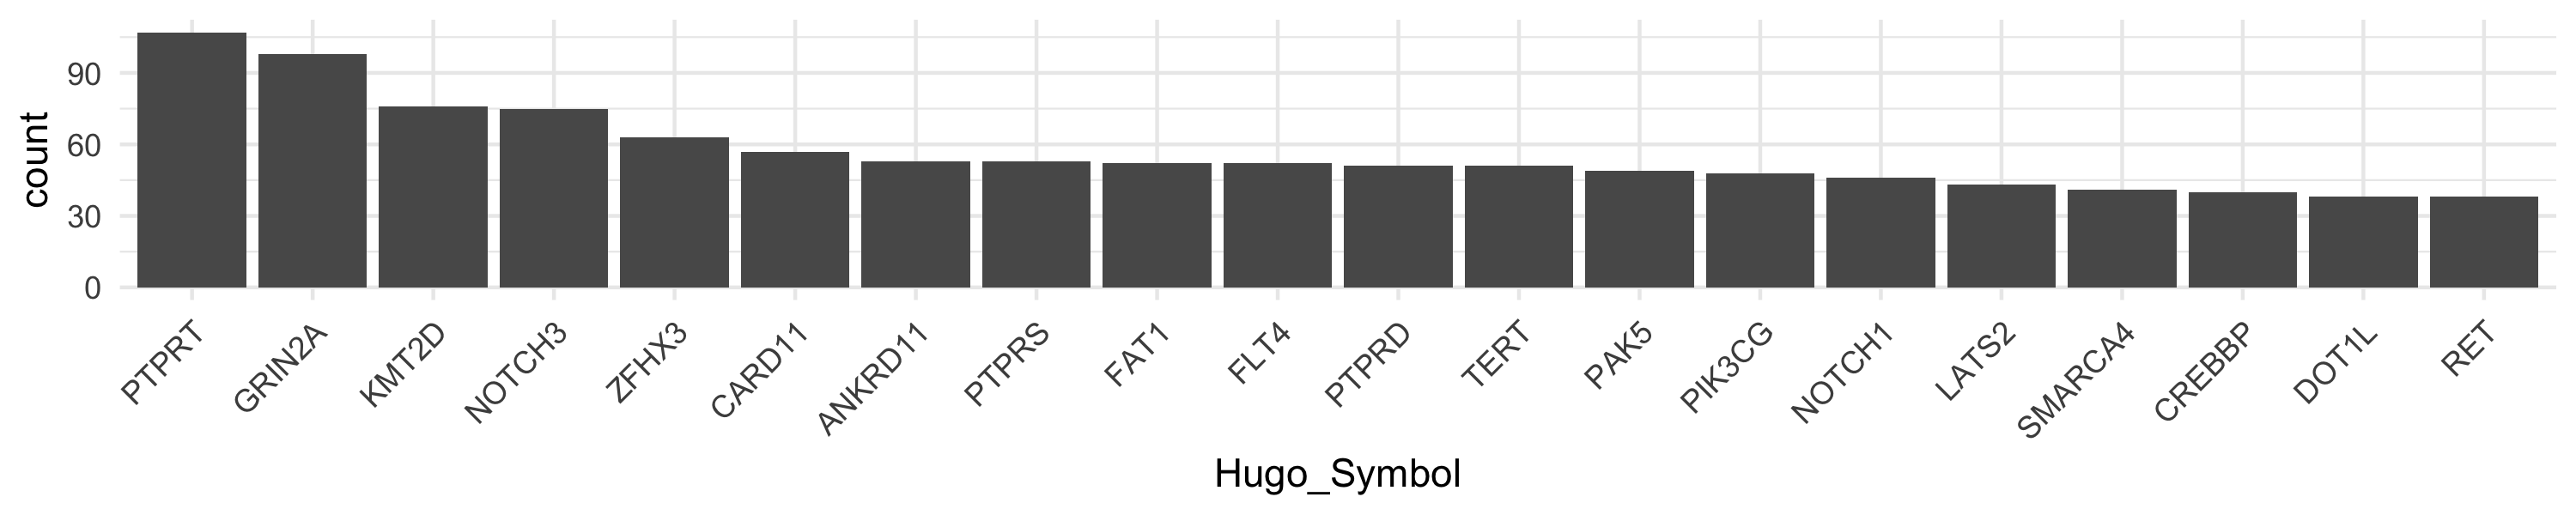

In [106]:
repeated_key <- sort_histogram(repeated_key, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(repeated_key) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(repeated_key, "Hugo_Symbol", 20) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

Here is a plot of the genes that are the most mutated **accross the rows**:

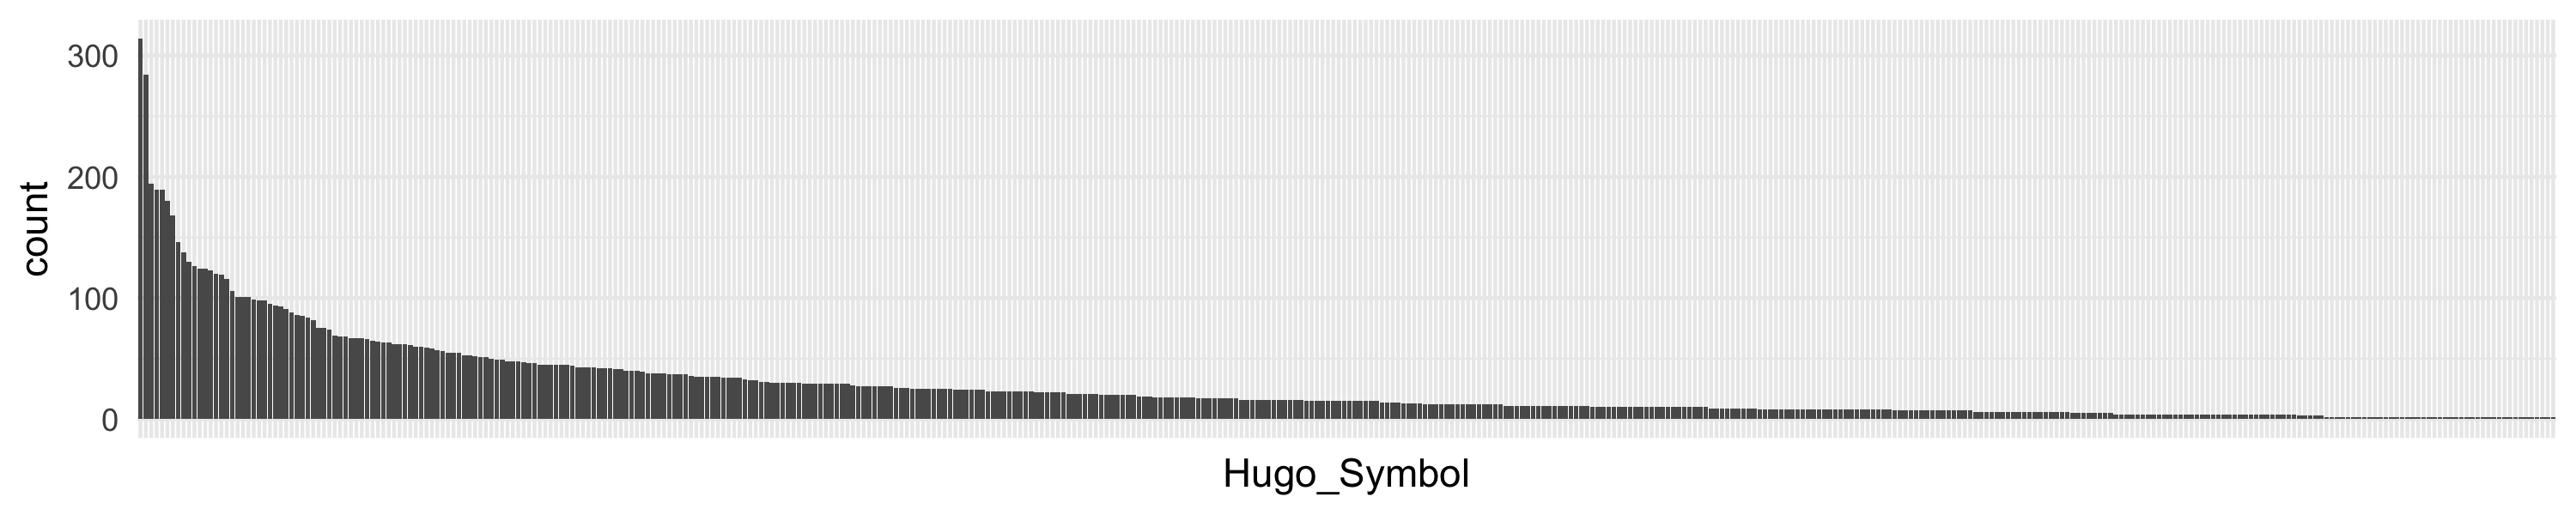

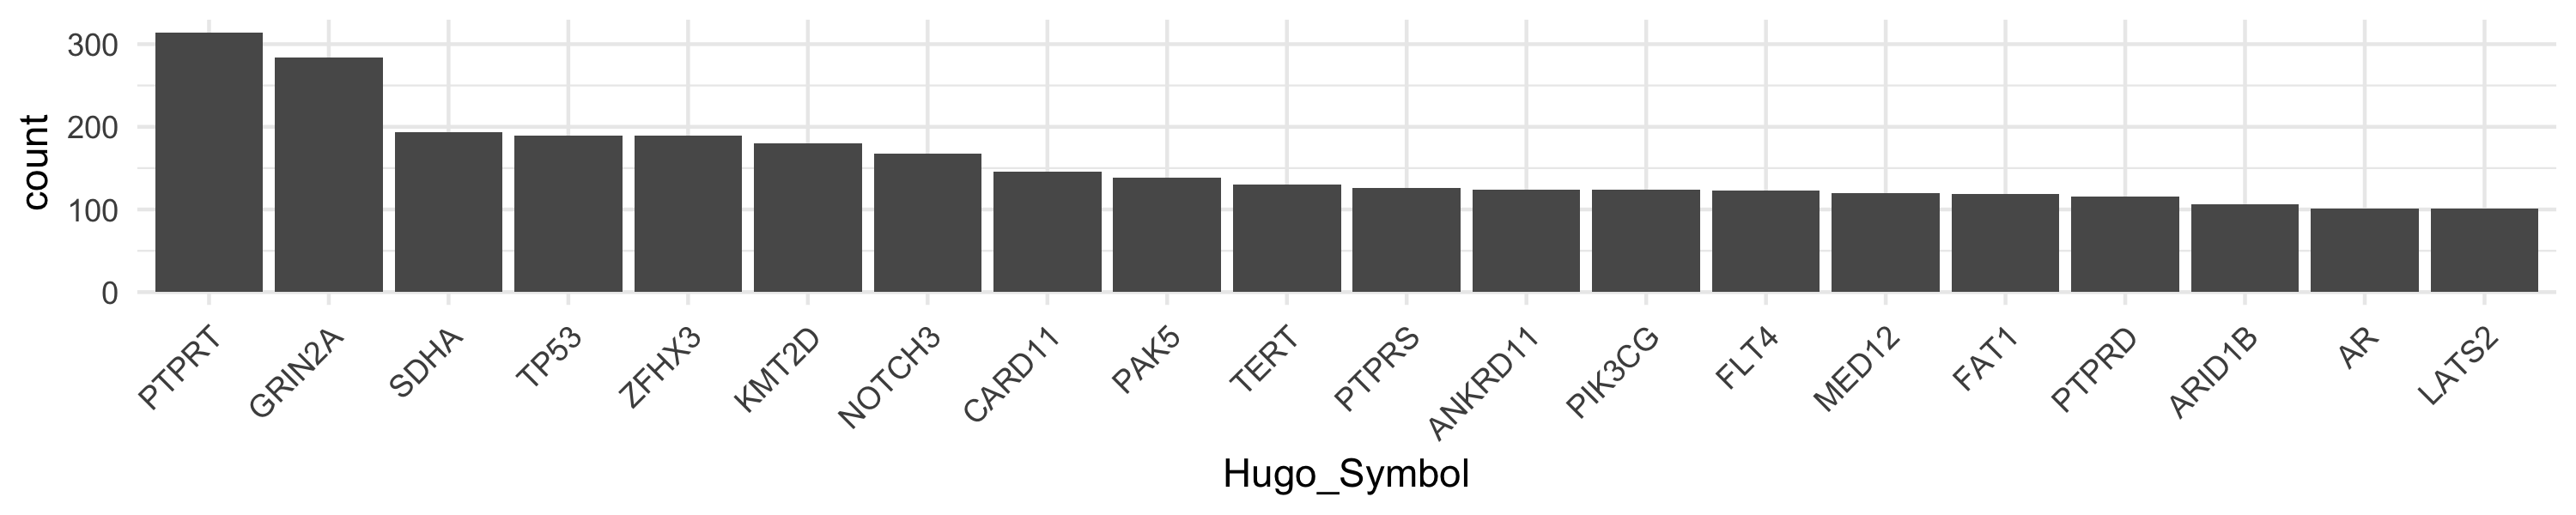

In [107]:
rec_impact <- impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% repeated_key$mut_key,]

rec_impact <- sort_histogram(rec_impact, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(rec_impact) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(rec_impact, "Hugo_Symbol", 20) + theme(axis.text.x = element_text(angle = 45, hjust = 1))

### Study the outliers

In [166]:
dd <- unique(impact %>% group_by(mut_key) %>%
           mutate(count = n()) %>%
           select(count, mut_key, Hugo_Symbol, Chromosome, cDNA_change, HGVSp_Short, Kaviar_AF, cosmic_count) %>%
           arrange(-count) %>% filter(count >= 20))

head(dd)

count,mut_key,Hugo_Symbol,Chromosome,cDNA_change,HGVSp_Short,Kaviar_AF,cosmic_count
42,X_66766359_C_T,AR,X,c.1371C>T,p.G457G,0.0001682,0
36,17_7579312_C_T,TP53,17,c.375G>A,p.T125T,0.0000065,18
35,17_7579312_C_A,TP53,17,c.375G>T,p.T125T,0.0000065,17
25,5_235397_T_G,SDHA,5,c.1203T>G,p.P401P,0.0000000,0
24,5_235403_C_G,SDHA,5,c.1209C>G,p.L403L,0.0000000,0
24,5_235406_C_G,SDHA,5,c.1212C>G,p.P404P,0.0000000,0


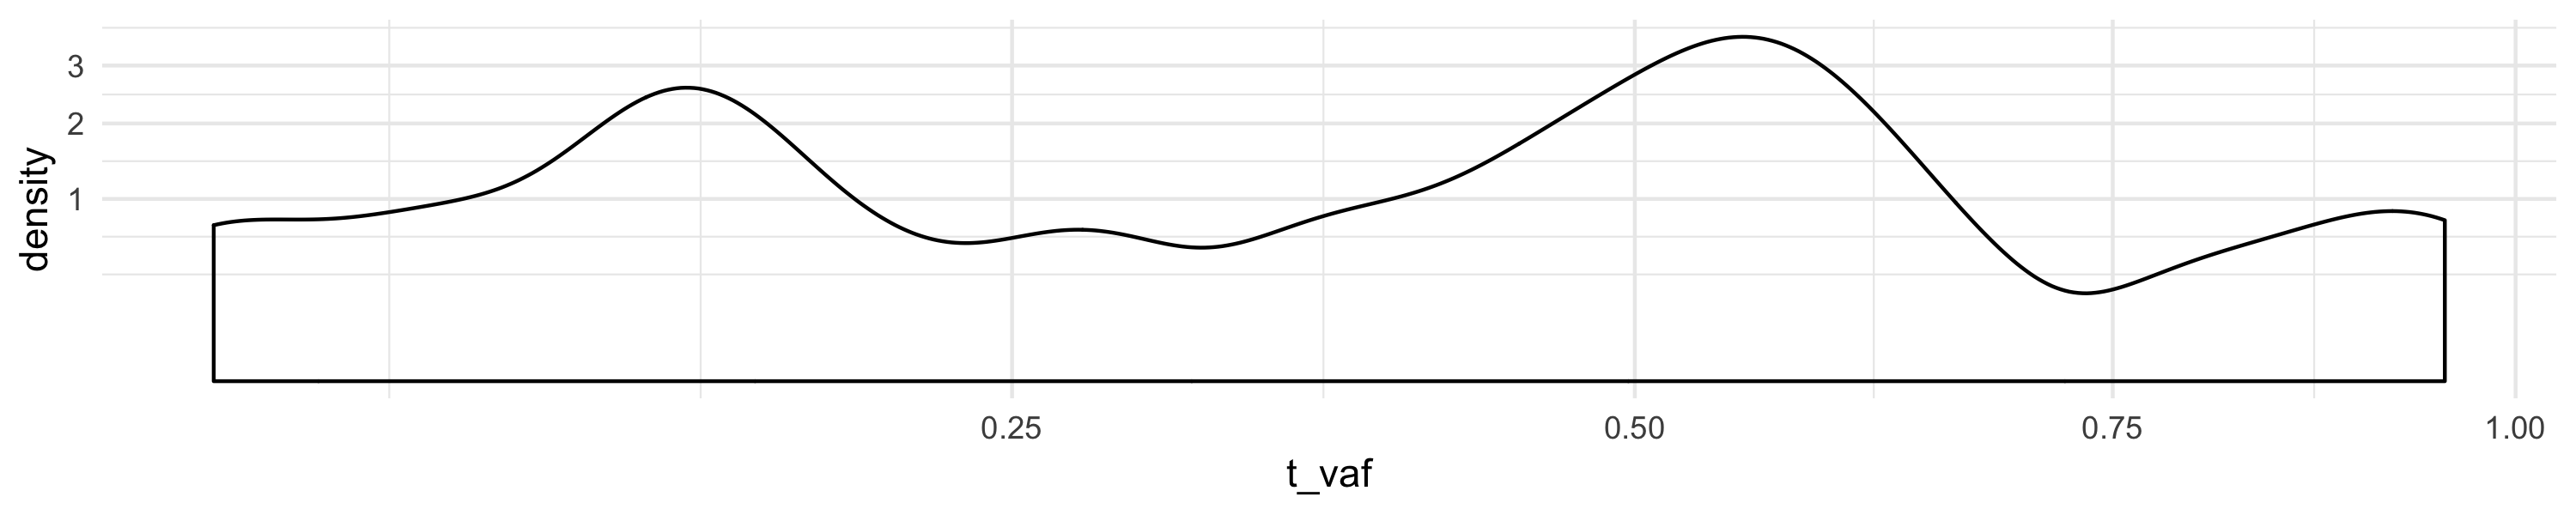

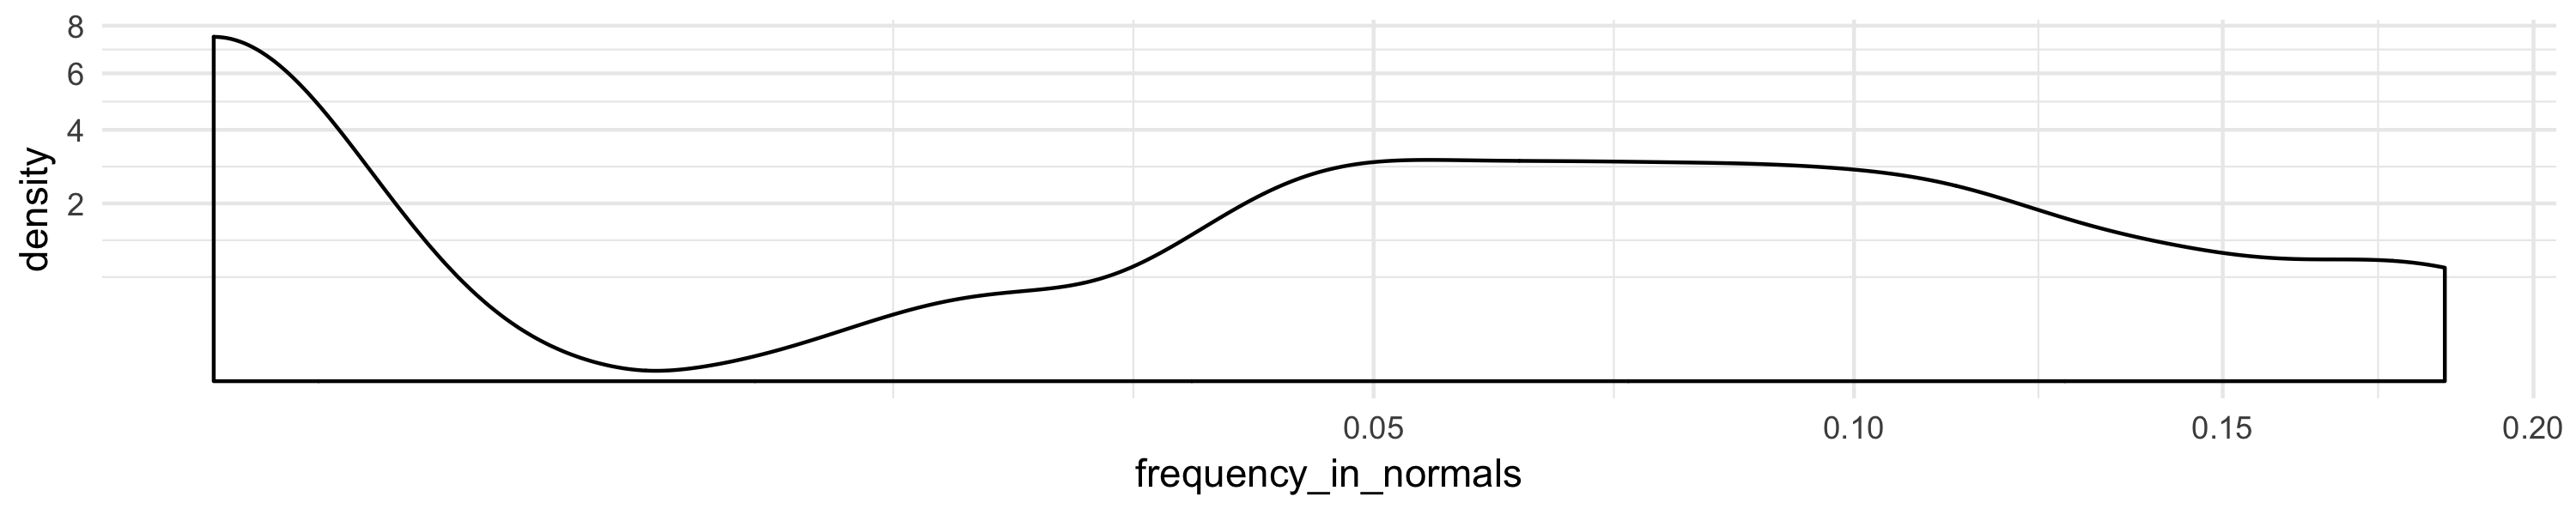

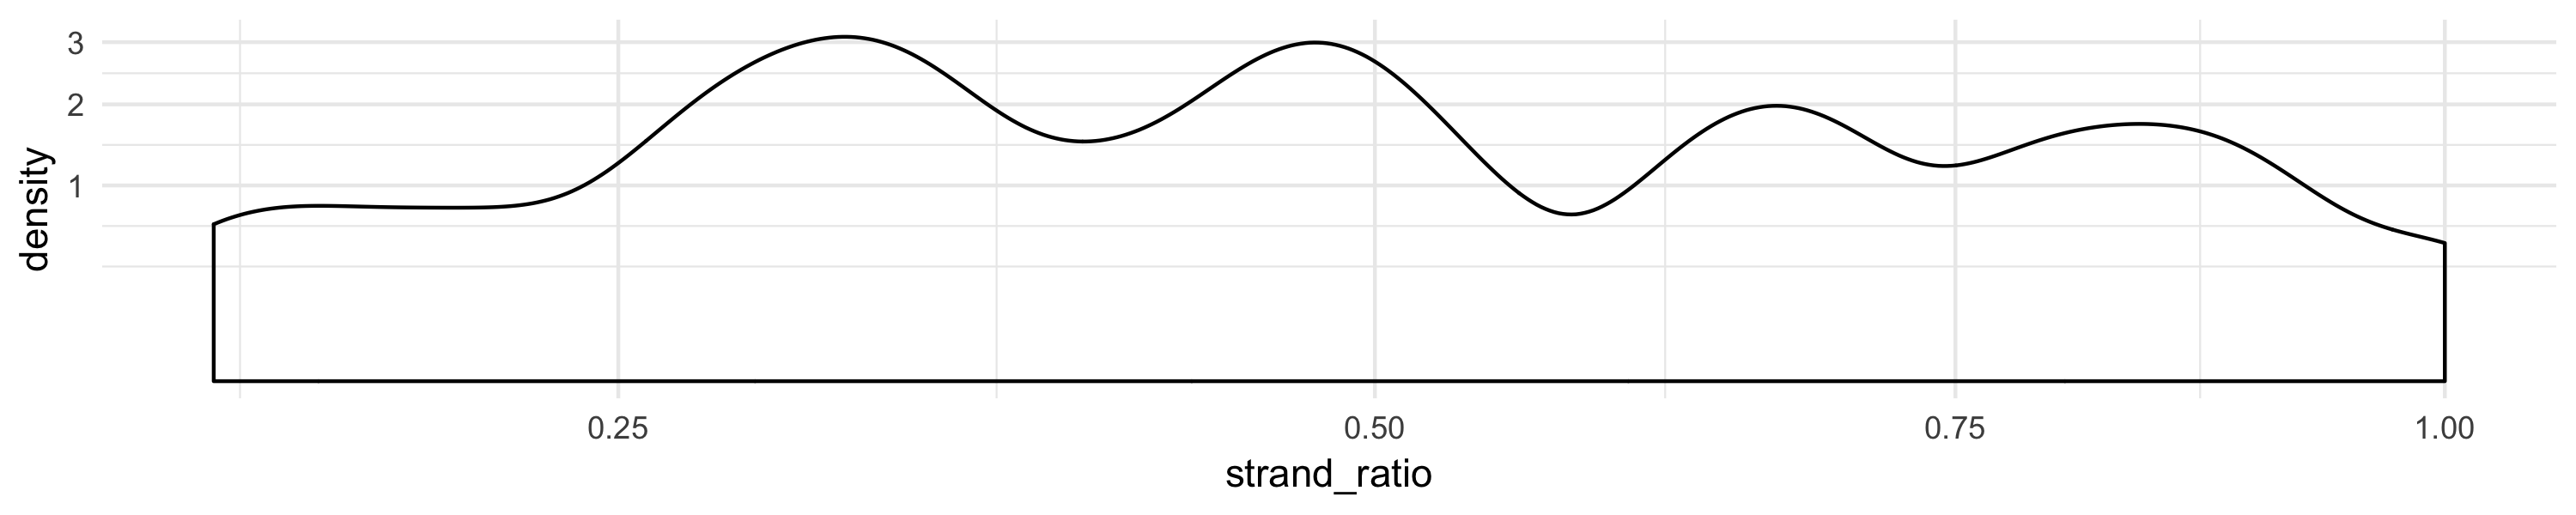

In [167]:
high <- impact[impact$mut_key == dd$mut_key[1],]

plot_density(high, "t_vaf", height = 2, adjust = 1/3) + scale_y_sqrt() + scale_x_sqrt()
plot_density(high, "frequency_in_normals", height = 2, adjust = 1/3) + scale_y_sqrt() + scale_x_sqrt()
plot_density(high, "strand_ratio", height = 2, adjust = 1/3) + scale_y_sqrt() + scale_x_sqrt()